<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Algorithms" data-toc-modified-id="1.-Algorithms-2">1. Algorithms</a></span><ul class="toc-item"><li><span><a href="#1.1-Augmented-Lagrangian-+-Conjugate-Gradient" data-toc-modified-id="1.1-Augmented-Lagrangian-+-Conjugate-Gradient-2.1">1.1 Augmented Lagrangian + Conjugate Gradient</a></span></li><li><span><a href="#1.2-Improved-Augmented-Lagrangian" data-toc-modified-id="1.2-Improved-Augmented-Lagrangian-2.2">1.2 Improved Augmented Lagrangian</a></span></li><li><span><a href="#1.3-Proximal-Gradient-Methods" data-toc-modified-id="1.3-Proximal-Gradient-Methods-2.3">1.3 Proximal Gradient Methods</a></span></li></ul></li><li><span><a href="#2.-Operators" data-toc-modified-id="2.-Operators-3">2. Operators</a></span></li><li><span><a href="#3.-Helper-functions" data-toc-modified-id="3.-Helper-functions-4">3. Helper functions</a></span></li><li><span><a href="#4.-PINCAT-phantom-example" data-toc-modified-id="4.-PINCAT-phantom-example-5">4. PINCAT phantom example</a></span><ul class="toc-item"><li><span><a href="#4.1-Preparation" data-toc-modified-id="4.1-Preparation-5.1">4.1 Preparation</a></span></li><li><span><a href="#4.2-Test-algorithms" data-toc-modified-id="4.2-Test-algorithms-5.2">4.2 Test algorithms</a></span></li></ul></li><li><span><a href="#5.-Multicoil-cardiac-cine-MRI" data-toc-modified-id="5.-Multicoil-cardiac-cine-MRI-6">5. Multicoil cardiac cine MRI</a></span><ul class="toc-item"><li><span><a href="#5.1-Preparation" data-toc-modified-id="5.1-Preparation-6.1">5.1 Preparation</a></span></li><li><span><a href="#5.2-Test-algorithms" data-toc-modified-id="5.2-Test-algorithms-6.2">5.2 Test algorithms</a></span></li></ul></li><li><span><a href="#6.-Multicoil-cardiac-perfusion-MRI" data-toc-modified-id="6.-Multicoil-cardiac-perfusion-MRI-7">6. Multicoil cardiac perfusion MRI</a></span><ul class="toc-item"><li><span><a href="#6.1-Preparation" data-toc-modified-id="6.1-Preparation-7.1">6.1 Preparation</a></span></li><li><span><a href="#6.2-Test-algorithms" data-toc-modified-id="6.2-Test-algorithms-7.2">6.2 Test algorithms</a></span></li></ul></li><li><span><a href="#7.-Multicoil-abdominal-dce-MRI" data-toc-modified-id="7.-Multicoil-abdominal-dce-MRI-8">7. Multicoil abdominal dce MRI</a></span><ul class="toc-item"><li><span><a href="#7.1-Preparation" data-toc-modified-id="7.1-Preparation-8.1">7.1 Preparation</a></span></li><li><span><a href="#7.2-Test-algorithms" data-toc-modified-id="7.2-Test-algorithms-8.2">7.2 Test algorithms</a></span></li></ul></li></ul></div>

In [7]:
using MAT, Plots, MIRT, LinearAlgebra, FFTW, FunctionOperators, OffsetArrays, IterativeSolvers,
    BenchmarkTools, ToeplitzMatrices, EllipsisNotation, Printf
include("helper_functions.jl")

BenchmarkTools.DEFAULT_PARAMETERS.gcsample = true
FFTW.set_num_threads(20)

┌ Info: Precompiling ToeplitzMatrices [c751599d-da0a-543b-9d20-d0a503d91d24]
└ @ Base loading.jl:1260


# 1. Algorithms

In [65]:
function update_H!(H, σ, ϵᵏ)
    for ind in CartesianIndices(H)
        i, j = ind[1], ind[2]
        H[ind] = 1 / (max(σ[i], ϵᵏ) * max(σ[j], ϵᵏ))
    end
end

function update_dH!(dH, σ, ϵᵏ, r̃)
    for j in eachindex(dH)
        dH[j] = 1 / (max(σ[r̃+1], ϵᵏ) * max(σ[j], ϵᵏ))
    end
end

function update_𝒟⁻¹!(𝒟⁻¹, H, dH, r̃, d₁, d₂)
    𝒟⁻¹[1:r̃*r̃] .= vec(H)
    𝒟⁻¹[r̃*r̃+1:r̃*(r̃+d₁)] .= vec(kron(dH, ones(1, d₁))')
    𝒟⁻¹[r̃*(r̃+d₁)+1:r̃*(r̃+d₁+d₂)] .= vec(kron(dH, ones(1, d₂)))
    #broadcast!(*, reshape(𝒟⁻¹[r̃*r̃+1:r̃*(r̃+d₁)], d₁, r̃)', dH, 1) # a bit overcomplicated repeat with transpose
    #broadcast!(*, reshape(𝒟⁻¹[r̃*(r̃+d₁)+1:r̃*(r̃+d₁+d₂)], r̃, d₂), dH, 1) # another overcomplicated repeat
    𝒟⁻¹ .= 1 ./ 𝒟⁻¹
end

update_𝒟⁻¹! (generic function with 1 method)

In [79]:
function get_P_operator(Uᵏ, Vᵏ, Vtᵏ, tempᵈ¹ˣᵈ², r̃, d₁, d₂, dType)
    
    tempᵈ¹ˣʳ, tempʳˣᵈ² = Array{dType}(undef, d₁, r̃), Array{dType}(undef, r̃, d₂)
    
    split(γ) = @views begin
        γ₁ = reshape(γ[1:r̃^2], r̃, r̃)
        γ₂ = reshape(γ[r̃*(r̃+d₁)+1:r̃*(r̃+d₁+d₂)], r̃, d₂)
        γ₃ = reshape(γ[r̃^2+1:r̃*(r̃+d₁)], d₁, r̃)
        γ₁, γ₂, γ₃
    end
    
    I_VV, I_UU = Array{dType}(undef, d₂, d₂), Array{dType}(undef, d₁, d₁)
    Iᵈ¹ˣᵈ¹, Iᵈ²ˣᵈ² = Diagonal(ones(d₁)), Diagonal(ones(d₂))
    
    Pᵏ = FunctionOperator{dType}(name="Pᵏ", inDims = (r̃*(r̃+d₁+d₂),), outDims = (d₁, d₂),
        forw = (b,γ) -> begin
                γ₁, γ₂, γ₃ = split(γ)
                # According to (2.169), the equation would be:
                # Uᵏ * γ₁ * Vᵏ' + Uᵏ * γ₂' * (I - Vᵏ*Vᵏ') + (I - Uᵏ*Uᵏ') * γ₃' * Vᵏ'
                # But as the columns of γ₂ are orthogonal to the ones in Uᵏ,
                # the rows of γ₃ are orthogonal to the columns of Vᵏ,
                # the expression can be simplified:
                # (Uᵏ * γ₁ + γ₃) * Vᵏ' + Uᵏ * γ₂
                # And this is implemented avoiding array re-allocations:
                mul!(tempᵈ¹ˣʳ, Uᵏ, γ₁)
                tempᵈ¹ˣʳ .+= γ₃
                mul!(b, tempᵈ¹ˣʳ, Vtᵏ)
                mul!(tempᵈ¹ˣᵈ², Uᵏ, γ₂)
                b .+= tempᵈ¹ˣᵈ²
            end,
        backw = (γ,Φᵃy) -> begin
                γ₁, γ₂, γ₃ = split(γ)
                # Things to do:
                # γ₁ .= Uᵏ' * Φᵃy * Vᵏ
                # γ₂ .= Uᵏ' * Φᵃy * (I - Vᵏ*Vᵏ')
                # γ₃ .= (I - Uᵏ*Uᵏ') * Φᵃy * Vᵏ
                # Efficient implementation:
                I_VV .= Iᵈ²ˣᵈ² .- mul!(I_VV, Vᵏ, Vtᵏ) # same as I - Vᵏ*Vtᵏ
                I_UU .= Iᵈ¹ˣᵈ¹ .- mul!(I_UU, Uᵏ, Uᵏ') # same as I - Uᵏ*Uᵏ'
                mul!(tempᵈ¹ˣʳ, Φᵃy, Vᵏ)
                mul!(γ₁, Uᵏ', tempᵈ¹ˣʳ)
                mul!(γ₃, I_UU, tempᵈ¹ˣʳ)
                mul!(tempʳˣᵈ², Uᵏ', Φᵃy)
                mul!(γ₂, tempʳˣᵈ², I_VV)
                γ
                #vcat(vec(γ₁), vec(γ₂), vec(γ₃))
            end)
    
    Pᵏ
end

get_P_operator (generic function with 2 methods)

In [83]:
function get_CG_operator(PᵃΦᵃΦP, 𝒟_weighting, tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾, r̃, d₁, d₂, dType)
    FunctionOperator{dType}(name = "CG_op", inDims = (r̃*(r̃+d₁+d₂),), outDims = (r̃*(r̃+d₁+d₂),),
        forw = (b,γ) ->  begin
            # An efficient implementation for:
            # b .= (ϵᵏ^2 * I / (𝒟⁻¹ - ϵᵏ^2 * I)) * γ + Pᵏ' * Φ' * Φ * Pᵏ * γ
            mul!(tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾, PᵃΦᵃΦP, γ)
            mul!(b, Diagonal(𝒟_weighting), γ)
            b .+= tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾
        end)
end

get_CG_operator (generic function with 2 methods)

In [87]:
function HM_IRLS(
        Xᴳᵀ::AbstractArray,                   # ground truth for MSE evaluation
        y::AbstractArray,                     # under-sampled data
        Φ::FunctionOperator;                  # sampling operator
        img_size::NTuple = size(Xᴳᵀ),            # size of output matrix
        r̃::Int = 0,                           # rank estimate of solution
        maxIter::Union{Int, Nothing} = nothing, # number of CG iteration steps
        N::Int = 10,                          # number of iterations
        verbose::Bool = false)                # print rank and loss value in each iteration
    
    # Initialize variables
    @assert 3 ≤ length(img_size) ≤ 4
    if length(img_size) == 3
        nx,ny,nt = img_size
        nc = size(y)[end]
    else
        nx,ny,nt,nc = img_size
    end
    dType = eltype(y)
    d₁, d₂ = nx*nx, nt
    y = reshape(y, :, nt, nc)
    Φ = reshape(Φ, inDims = (d₁, d₂), outDims = size(y))
    Xᴳᵀ = reshape(Xᴳᵀ, d₁, d₂)
    r̃ == 0 && (r̃ = rank(Xᴳᵀ))
    maxIter = maxIter isa Nothing ? r̃*(r̃+d₁+d₂) : maxIter
    ϵᵏ = Inf
    Xᵏ = Φ' * y
    
    # Preallocate arrays
    F = svd(Xᵏ)
    Uᵏ, σ, Vᵏ, Vtᵏ = F.U[:, 1:r̃], F.S, F.V[:, 1:r̃], F.Vt[1:r̃, :]
    Hᵏᵤᵥ = Array{dType}(undef, r̃, r̃)
    dHᵏ = Array{dType}(undef, r̃, 1)
    𝒟⁻¹, 𝒟_weighting, b, γᵏ, tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾ = [Vector{dType}(undef, r̃*(r̃+d₁+d₂)) for _ in 1:5]
    tempᵈ¹ˣᵈ² = Array{dType}(undef, d₁, d₂)
    rᵏ, γᵏ_tilde = similar(y), similar(γᵏ)
    statevars = IterativeSolvers.CGStateVariables(similar(γᵏ), similar(γᵏ), similar(γᵏ))
    
    # Create operators
    Pᵏ= get_P_operator(Uᵏ, Vᵏ, Vtᵏ, tempᵈ¹ˣᵈ², r̃, d₁, d₂, dType)
    PᵃΦᵃΦP = Pᵏ' * Φ' * Φ * Pᵏ
    ΦP, PᵃΦᵃ = Φ * Pᵏ, Pᵏ' * Φ'
    CG_op = get_CG_operator(PᵃΦᵃΦP, 𝒟_weighting, tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾, r̃, d₁, d₂, dType)
    
    for k in 1:N
        
        svd!(tempᵈ¹ˣᵈ² .= Xᵏ, F)
        @views begin Uᵏ .= F.U[:, 1:r̃]; Vᵏ .=  F.V[:, 1:r̃]; Vtᵏ .= F.Vt[1:r̃, :]; end
        
        ϵᵏ = min(ϵᵏ, σ[r̃+1])
        
        r, n, s, e = sum(σ .> 1e-3), opnorm(tempᵈ¹ˣᵈ² .= Xᴳᵀ .- Xᵏ, 2), σ[1], ϵᵏ
        n, s, e = @sprintf("%.3f", n), @sprintf("%.3f", s), @sprintf("%.3f", e)
        println("k = $(k-1),\trank(Xᵏ) = $r,\t‖Xᴳᵀ - Xᵏ‖₂ = $n, σ₁ = $s, ϵᵏ = $e")
        
        update_H!(Hᵏᵤᵥ, σ, ϵᵏ)
        update_dH!(dHᵏ, σ, ϵᵏ, r̃)
        update_𝒟⁻¹!(𝒟⁻¹, Hᵏᵤᵥ, dHᵏ, r̃, d₁, d₂)
        
        # An efficient implementation of 𝒟_weighting = ϵᵏ^2 * I / (𝒟⁻¹ - ϵᵏ^2 * I):
        𝒟_weighting .= ϵᵏ^2 ./ (𝒟⁻¹ .- ϵᵏ^2)
        
        mul!(b, PᵃΦᵃ, y) # right hand side for CG
        mul!(γᵏ, Pᵏ', Xᵏ) # initial value for CG
        
        cg!(γᵏ, CG_op, b, maxiter = maxIter, statevars = statevars, verbose = true) # 2.167
        
        # An efficient implementation of rᵏ = y - Φ * Pᵏ * γᵏ:
        rᵏ .= y .- mul!(rᵏ, ΦP,  γᵏ)
        
        # An efficient implementation of γᵏ_tilde = Diagonal(𝒟⁻¹ ./ (𝒟⁻¹ .- ϵᵏ^2)) * γᵏ - Pᵏ' * Φ' * rᵏ
        𝒟_weighting .= 𝒟⁻¹ ./ (𝒟⁻¹ .- ϵᵏ^2) # same as Diagonal(𝒟⁻¹ ./ (𝒟⁻¹ .- ϵᵏ^2))
        mul!(tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾, PᵃΦᵃ, rᵏ)
        mul!(γᵏ_tilde, Diagonal(𝒟_weighting), γᵏ)
        γᵏ_tilde .-= tempʳ⁽ʳ⁺ᵈ¹⁺ᵈ²⁾
        
        # An efficient implementation of Xᵏ = Φ' * rᵏ + Pᵏ * γᵏ_tilde
        mul!(Xᵏ, Pᵏ, γᵏ_tilde)
        Xᵏ .+= mul!(tempᵈ¹ˣᵈ², Φ', rᵏ)   # 2.168
        
    end
    
    r, n, s, e = sum(svdvals(Xᵏ) .> 1e-3), opnorm(Xᴳᵀ - Xᵏ, 2), σ[1], ϵᵏ
    n, s, e = @sprintf("%.3f", n), @sprintf("%.3f", s), @sprintf("%.3f", e)
    println("k = $N,\trank(Xᵏ) = $r,\t‖Xᴳᵀ - Xᵏ‖₂ = $n, σ₁ = $s, ϵᵏ = $e")
    
    Xᵏ
end

HM_IRLS (generic function with 1 method)

The algorithms below are described in [this paper](https://web.eecs.umich.edu/~fessler/papers/files/jour/19/web/lin-19-edp.pdf) by Claire Yilin Lin, and Jeffrey A. Fessler, and follows their [original implementation in Matlab](https://github.com/JeffFessler/reproduce-l-s-dynamic-mri).

## 1.1 Augmented Lagrangian + Conjugate Gradient

**Problem formulation:** $argmin_{L,S}min_{U,W}\{\frac{1}{2}\lVert \textbf{E}(L+S) -d \lVert_2^2 + \lambda_L \lVert P \lVert_* + \lambda_S \lVert Q \lVert_1\} \textrm{ subject to } \begin{cases} P = L \\ Q = \textbf{T}S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \textbf{E}(L+S) - d \lVert_2^2 + \lambda_L \lVert P \lVert_* + \lambda_S \lVert Q \lVert_1\ + \frac{\delta_1}{2} \lVert L - P + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert \textbf{T}S - Q + V_2 \lVert_2^2$

**Inputs:**

 - $d$: under-sampled multi-coil k-t data
 - $\textbf{E}$: Acquisition operator
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $iterL$: number of conjugate gradient iteration steps for $S$
 - $iterL$: number of conjugate gradient iteration steps for $L$
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $L_0 = \textbf{E}^∗ d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $P_k \leftarrow \textbf{SVT}_{\lambda_L / \delta_1} (L+V_2)$
 - $Q_k \leftarrow \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}S) + V_2 $
 - $L_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_1\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}S + \delta_1(P-V_1) \textrm{ starting from }L_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $S_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_2\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}L + \delta_2(Q-V_2) \textrm{ starting from }S_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $V_{1,k} \leftarrow V_{1,k-1} + L_k - P$
 - $V_{2,k} \leftarrow V_{2,k-1} + \textbf{T}S_k - Q$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_CG.m

In [9]:
function AL_CG(d::AbstractArray,              # under-sampled k-t data
        E::FunctionOperator,                  # acquisition operator
        T::FunctionOperator;                  # temporal Fourier tranform
        img_shape::NTuple = size(d),          # size of output image
        scale_L::Real = 1,                    # scaling factor for L
        scale_S::Real = 1,                    # scaling factor for S
        λ_L::Real = 0.01,                     # singular value threshold
        λ_S::Real = 0.05,                     # sparsity threshold
        δ₁::Real = 1//10,                     # first AL penalty parameter
        δ₂::Real = 1//100,                    # second AL penalty parameter
        iterL::Int = 3,                       # number of CG iteration steps for S
        iterS::Int = iterL,                   # number of CG iteration steps for L
        N::Int = 10,                          # number of iterations
        verbose::Bool = false)                # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, λ_L, λ_S, δ₁, δ₂ = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, λ_L), convert(floatType, λ_S), convert(floatType, δ₁), convert(floatType, δ₂)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    d = reshape(d, :, nt, nc)
    E = reshape(E, inDims = (nx*nx, nt), outDims = size(d))
    x₀ = E' * d # initial guess
    
    L, S = copy(x₀), zeros(complexType, size(x₀))
    V₁, V₂ = zeros(complexType, size(L)), zeros(complexType, size(L))
    
    cost = getCost(E, T, d, scale_L*λ_L, scale_S*λ_S, size(L), (nx*ny, nt, nc), complexType)
    SVT! = getSVT()
    
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(L, S)
    rank_vec[0] = rank(L)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    cg_tol = convert(floatType, 1e-5)
    P, Q = similar(L), similar(L)
    temp₁, temp₂ = similar(L), similar(L)
    EᴴE_op, Tᴴ = E'*E, T'
    cg_op₁, cg_op₂ = EᴴE_op + δ₁*I, EᴴE_op + δ₂*I
    CGstate = CGStateVariables(temp₂, similar(L), similar(L))
    for k in 1:N
        
        P = SVT!(P .= L .+ V₁, scale_L * λ_L / δ₁)
        Q = Λ!(mul!(Q, T, S) .+= V₂, scale_S * λ_S / δ₂)
        
        temp₁ .= x₀ .- mul!(temp₁, EᴴE_op, S) .+ δ₁.*(temp₂ .= P .- V₁)
        cg!(L, cg_op₁, temp₁, tol=cg_tol, maxiter=iterL, statevars=CGstate)
        
        mul!(temp₂, Tᴴ, temp₁ .= Q .- V₂)
        temp₁ .= x₀ .- mul!(temp₁, EᴴE_op, L) .+ δ₂.*temp₂
        cg!(S, cg_op₂, temp₁, tol=cg_tol, maxiter=iterS, statevars=CGstate)
        
        V₁ .+= L .- P
        V₂ .+= mul!(temp₁, T, S) .- Q
        
        cost_vec[k] = cost(L, S)
        rank_vec[k] = rank(L)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), rank_vec, cost_vec
end

AL_CG (generic function with 1 method)

## 1.2 Improved Augmented Lagrangian

**Problem formulation:** $argmin_{L,S}min_{Z,X}\{\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1\} \textrm{ subject to } \begin{cases} Z = \textbf{QC}X \\ X = L+S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1 + \frac{\delta_1}{2} \lVert Z - \textbf{QC} + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X - (L+S) + V_2 \lVert_2^2$

**Inputs:**
 - $d$: under-sampled multi-coil k-t data
 - $\boldsymbol{\Omega}$: under-sampling mask
 - $\textbf{Q}$: Fourier encoding operator
 - $\textbf{C}$: coil sensitivity maps
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $X_0 = L_0 = C∗Q∗Ω∗d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $Z_k \leftarrow argmin_Z \frac{1}{2} \lVert\boldsymbol{\Omega} Z-d\lVert_2^2 + \frac{\delta_1}{2}\lVert X - (L+S) + V_2\lVert_2^2 = (\boldsymbol{\Omega}^*\boldsymbol{\Omega} + \delta_1 \textbf{I})^{-1}(\boldsymbol{\Omega}^*d + \delta_1(\textbf{Q}\textbf{C}X - V_1))$
 - $X_k \leftarrow argmin_X \frac{\delta_1}{2} \lVert Z-\textbf{QC}X+V\_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X-(L+S) + V_2 \lVert_2^2$ $ = (\textbf{C}^*\textbf{C} + \frac{\delta_1}{\delta_2}\textbf{I})^{-1}(\textbf{C}^*\textbf{Q}^*(Z+V_1)+\frac{\delta_1}{\delta_2}(L+S+V_2)) = \frac{\delta_1}{\delta_1+\delta_2}(\textbf{C}^*\textbf{Q}^*(Z+V_1) + \frac{\delta_2}{\delta_1}(L+S-V_2))$
 - $L_k \leftarrow argmin_L (\lambda_L \lVert L \lVert_* + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2) = \textbf{SVT}_{\lambda_L / \delta_2} (X-S+V_2)$
 - $S_k \leftarrow argmin_S (\lambda_S \lVert \textbf{T} S \lVert_1 + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2)$ $ = \textbf{T}^* (argmin_S (\lambda_S \lVert \tilde{S} \lVert_1 + \frac{\delta_2}{2} \lVert \textbf{T}(X - (L + S) + V_2) - \tilde{S} \lVert_2^2)$ $ = \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}(X - L + V_2)) $ where $\tilde{S} = \textbf{T}S$
 - $V_{1,k} \leftarrow V_{1,k-1} + (Z_k − \textbf{QC}X_k)$
 - $V_{2,k} \leftarrow V_{2,k-1} + X_k − (L_k + S_k)$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_2.m

In [10]:
function AL_2(d::AbstractArray,               # under-sampled k-t data
        Ω::FunctionOperator,                  # under-sampling mask
        Q::FunctionOperator,                  # Fourier encoding operator
        C::FunctionOperator,                  # coil sensitivity maps
        T::FunctionOperator;                  # temporal Fourier tranform
        img_shape::NTuple = size(d),          # size of output image
        scale_L::Real = 1,                    # scaling factor for L
        scale_S::Real = 1,                    # scaling factor for S
        λ_L::Real = 0.01,                     # singular value threshold
        λ_S::Real = 0.05,                     # sparsity threshold
        δ₁::Real = 1//10,                     # first AL penalty parameter
        δ₂::Real = 1//100,                    # second AL penalty parameter
        N::Int = 10,                          # number of iterations
        verbose::Bool = false)                # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, λ_L, λ_S, δ₁, δ₂ = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, λ_L), convert(floatType, λ_S), convert(floatType, δ₁), convert(floatType, δ₂)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    E = reshape(Ω * Q * C, inDims = (nx*nx, nt), outDims = size(d))
    QC = reshape(Q * C, inDims = (nx*nx, nt), outDims = size(d))
    # I plan to implement reshape on FunctionOperators to avoid these ugly constructs...
    Tᴴ, QCᴴ = T', QC'
    
    L = reshape(E' * d, nx*ny, nt) # initial guess
    S = zeros(complexType, size(L))
    X = L + S
    V₁ = zeros(complexType, size(d))
    V₂ = zeros(complexType, size(L))
    Z_scaler = repeat(1 ./ (samp .+ δ₁), 1, 1, 1, nc) # equivalent to (Ω'*Ω + δ₁*I)'
    
    cost = getCost(E, T, d, scale_L*λ_L, scale_S*λ_S, size(L), size(d), complexType)
    SVT! = getSVT()
    
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(L, S)
    rank_vec[0] = rank(L)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    # Iteration
    temp₁, temp₂, Z, temp₃, temp₄ = similar(L), similar(L), similar(d), similar(d), similar(d)
    for k in 1:N
        temp₃ .= d #mul!(temp₃, Ω', d)
        mul!(temp₄, QC, X)
        Z .= Z_scaler .* (temp₃ .+ δ₁ .* (temp₄ .- V₁))
        
        mul!(temp₁, QCᴴ, temp₃ .= Z .+ V₁)
        temp₂ .= L .+ S .- V₂
        X .= δ₁./(δ₁ .+ δ₂).*temp₁ .+ δ₂./(δ₁ .+ δ₂).*temp₂
        
        L = SVT!(L .= X .- S .+ V₂, scale_L * λ_L / δ₂)
        
        mul!(temp₁, T, temp₁ .= X .- L .+ V₂)
        mul!(S, Tᴴ, Λ!(temp₁, scale_S * λ_S / δ₂))
        
        mul!(temp₃, QC, X)
        V₁ .+= Z .- temp₃
        
        V₂ .+= X .- L .- S
        
        cost_vec[k] = cost(L, S)
        rank_vec[k] = rank(L)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), rank_vec, cost_vec
end

AL_2 (generic function with 1 method)

## 1.3 Proximal Gradient Methods

**Inputs:**

 - $d$: under-sampled k-t data
 - $\textbf{E}$: data acquisition operator
 - $\textbf{T}$: temporal Fourier transform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $N$: number of iterations
 - $momentum$: update rule (ISTA/FISTA/POGM)
 
**Initialization:** $M_0 = L_0 = \tilde{L}_0 = \bar{L}_0 = E∗d, S_0 = 0, \theta_0 = \zeta_0 = 1, t = 0.5 \textrm{ (for FISTA and POGM) or } 0.99 \textrm{ (for ISTA)}$

for $k = 1, 2, ... , N$ do

 - $\tilde{L}_k \leftarrow M_{k-1} - S_{k-1}$
 - $\tilde{S}_k \leftarrow M_{k-1} - L_{k-1}$
 - $\theta_k \leftarrow \begin{cases} \frac{1+\sqrt{1 + 4\theta_{k-1}^2}}{2} \\ \frac{1+\sqrt{1 + 8\theta_{k-1}^2}}{2} \end{cases}$
 - $\bar{X}_k \leftarrow \begin{cases} \tilde{X}_k : momentum = ISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) : momentum = FISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) + \frac{\theta_{k-1}-1}{\zeta_{k-1} \theta_k}(\bar{X}_{k-1} - X_{k-1}) : momentum = POGM \end{cases}$
 - $\zeta_k \leftarrow t(1+\frac{\theta_{k-1}-1}{\theta_k} + \frac{\theta_{k-1}}{\theta_k})$
 - $L_k \leftarrow \textbf{SVT}_{\lambda_L}(\bar{L}_k)$
 - $S_k \leftarrow \textbf{T}^*(\Lambda_{\lambda_S}[\textbf{T}(\bar{S}_k)])$
 - $M_k \leftarrow L_k + S_k - t\textbf{E}^* (\textbf{E}(L_k +S_k)-d)$

end for

**output:** $X_N$

This funciton creates the following construct: $X = \begin{bmatrix}L \\ S\end{bmatrix}$ in such a way that modifying $L$ or $S$ also takes effect in $X$, and vice versa.

In [11]:
function createXLS(dType, row_dim, nt)
    X = zeros(dType, row_dim, 2*nt)
    L = view(X, :, 1:nt)
    S = view(X, :, nt + 1:2*nt)
    return X,L,S
end
function allocate(dType, row_dim, nt)
    createXLS(dType, row_dim, nt)..., createXLS(dType, row_dim, nt)...
end

allocate (generic function with 1 method)

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/PGM.m

In [12]:
function PGM(d::AbstractArray,              # under-sampled k-t data
        E::FunctionOperator,                # acquisition operator
        T::FunctionOperator;                # sparsifying operator
        img_shape::NTuple = size(d),        # size of output image
        scale_L::Real = 1,                  # scaling factor for L
        scale_S::Real = 1,                  # scaling factor for S
        tscale::Real = 1,                   # scaling factor for t
        λ_L::Real = 0.01,                   # singular value threshold
        λ_S::Real = 0.05,                   # sparsity threshold
        N::Int = 10,                        # number of iterations
        restart::Bool = true,               # reset θₖ if cost increased
        momentum::Symbol = :pogm,           # update rule (:pogm, :ista, :fista)
        verbose::Bool = false)              # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, tscale, λ_L, λ_S = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, tscale), convert(floatType, λ_L), convert(floatType, λ_S)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    row_dim = nx*ny
    d = reshape(d, :, nt, nc)
    E = reshape(E, inDims = (row_dim, nt), outDims = size(d))
    x₀ = E' * d # initial guess
    
    Xₖ₋₁,Lₖ₋₁,Sₖ₋₁,Xₖ,Lₖ,Sₖ = allocate(complexType, row_dim, nt)
    X̃ₖ₋₁,L̃ₖ₋₁,S̃ₖ₋₁,X̃ₖ,L̃ₖ,S̃ₖ = allocate(complexType, row_dim, nt)
    if momentum == :pogm
        X̄ₖ₋₁,L̄ₖ₋₁,S̄ₖ₋₁,X̄ₖ,L̄ₖ,S̄ₖ = allocate(complexType, row_dim, nt)
    else
        X̄ₖ₋₁,L̄ₖ₋₁,S̄ₖ₋₁,X̄ₖ,L̄ₖ,S̄ₖ = X̃ₖ₋₁,L̃ₖ₋₁,S̃ₖ₋₁,X̃ₖ,L̃ₖ,S̃ₖ
    end
    Lₖ₋₁ .= x₀
    X̄ₖ₋₁ .= X̃ₖ₋₁ .= Xₖ₋₁
    temp₁, temp₂ = similar(Lₖ₋₁), similar(d)
    Eᴴ, Tᴴ = E', T'
    
    t = (in(momentum, (:fista, :pogm)) ? 5//10 : 99//100) * tscale
    
    mul!(temp₂, E, x₀)
    mul!(temp₁, E', temp₂ .-= d)
    Mₖ = Mₖ₋₁ = x₀ .- t .* temp₁ # we don't need two arrays for M, but it looks better this way
    
    θₖ₋₁ = ζₖ₋₁ = 1.
    
    cost = getCost(E, T, d, scale_L*λ_L, scale_S*λ_S, size(Lₖ₋₁), size(d), complexType)
    SVT! = getSVT()
    
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(Lₖ₋₁, temp₁ .= Sₖ₋₁) # T operator in cost function doesn't like subarrays
    rank_vec[0] = rank(Lₖ₋₁)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    # Iteration
    for k in 1:N
        @. L̃ₖ = Mₖ₋₁ - Sₖ₋₁
        @. S̃ₖ = Mₖ₋₁ - Lₖ₋₁
        
        θₖ  = (1 + √(1 + (k < N ? 4 : 8)*θₖ₋₁^2))/2
        
        if momentum == :pogm
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁) +
                (θₖ₋₁)/θₖ*(X̃ₖ - Xₖ₋₁) + (θₖ₋₁-1)/(ζₖ₋₁*θₖ)*t*(X̄ₖ₋₁ - Xₖ₋₁)
        elseif momentum == :fista
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁)
        else
            # nothing to do as X̄ₖ == X̃ₖ
        end
        
        ζₖ  = t*(1 + (θₖ₋₁-1)/θₖ + (θₖ₋₁)/θₖ)
        
        SVT!(Lₖ .= L̄ₖ, scale_L*λ_L)
        
        mul!(temp₁, T, temp₁ .= S̄ₖ) # T operator in doesn't like subarrays
        mul!(temp₁, Tᴴ, Λ!(temp₁, scale_S*λ_S))
        Sₖ .= temp₁
        
        mul!(temp₂, E, temp₁ .= Lₖ .+ Sₖ)
        mul!(temp₁, Eᴴ, temp₂ .-= d)
        @. Mₖ = Lₖ + Sₖ - t * temp₁
        
        cost_vec[k] = cost(Lₖ, temp₁ .= Sₖ) # T operator in cost function doesn't like subarrays
        rank_vec[k] = rank(Lₖ)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
        
        if restart && cost_vec[k] > cost_vec[k - 1]
            θₖ₋₁ = θₖ = convert(floatType, 1)
            verbose && println("   Restarted!")
        end
        
        # Move (k) -> (k-1), and avoid allocation for new (k)
        #      => switch (k) and (k-1) matrices
        @swap(Xₖ₋₁, Xₖ); @swap(X̃ₖ₋₁, X̃ₖ); @swap(X̄ₖ₋₁, X̄ₖ)
        @swap(Lₖ₋₁, Lₖ); @swap(L̃ₖ₋₁, L̃ₖ); @swap(L̄ₖ₋₁, L̄ₖ)
        @swap(Sₖ₋₁, Sₖ); @swap(S̃ₖ₋₁, S̃ₖ); @swap(S̄ₖ₋₁, S̄ₖ)
        @swap(Mₖ₋₁, Mₖ)
        θₖ₋₁, ζₖ₋₁ = θₖ, ζₖ
    end
    
    reshape(Lₖ, nx, ny, nt), reshape(Sₖ, nx, ny, nt), rank_vec, cost_vec
end

PGM (generic function with 1 method)

# 2. Operators
**All-in-one acquisition operator**

In [13]:
function getE(nx::Int, ny::Int, nt::Int, nc::Int, samp::AbstractArray{T,3} where T,
        smap::AbstractArray{Complex{T},3} where T, dType::Type)
    scaling = convert(dType, √(nx*ny))
    mask_with_scaling = repeat(samp, 1, 1, 1, nc) .* scaling
    reshaped_smap = reshape(convert.(dType, smap), nx, ny, 1, nc)
    reshaped_smap_conj_with_scaling = conj.(reshaped_smap) ./ scaling
    xcoils₁ = Array{dType}(undef, nx, ny, nt, nc)
    xcoils₂ = Array{dType}(undef, nx, ny, nt, nc)
    FFT_plan = plan_fft(xcoils₁, (1,2))
    iFFT_plan = inv(FFT_plan)
    E = FunctionOperator{dType}(name = "E", 
        forw = (b, x) -> begin # Don't ask me, why did Mr Otazo use ifft instead of fft...
                xcoils₁ .= reshape(x, (nx, ny, nt, 1)) .* reshaped_smap
                ifftshift!(xcoils₂, xcoils₁, (1, 2))
                mul!(xcoils₁, iFFT_plan, xcoils₂)
                fftshift!(b, xcoils₁, (1, 2))
                b .*= mask_with_scaling
            end,
        backw = (b, y) -> begin # But he used it consistently, so it doesn't make a big difference
                ifftshift!(xcoils₂, y, (1, 2))
                mul!(xcoils₁, FFT_plan, xcoils₂)
                fftshift!(xcoils₂, xcoils₁, (1, 2))
                xcoils₂ .*= reshaped_smap_conj_with_scaling
                sum!(reshape(b, (nx, ny, nt, 1)), xcoils₂)
                b
            end,
        inDims = (nx, ny, nt), outDims = (nx, ny, nt, nc))
end

getE (generic function with 1 method)

**Components of acquisition operator separately**

In [14]:
function getΩQC(nx::Int, ny::Int, nt::Int, nc::Int, samp::AbstractArray{T,3} where T,
        smap::AbstractArray{Complex{T},3} where T, dType::Type)
    mask = repeat(convert.(dType, samp), 1, 1, 1, nc)
    reshaped_smap = reshape(convert.(dType, smap), nx, ny, 1, nc)
    reshaped_smap_conj = conj.(reshaped_smap)
    xcoils = Array{dType}(undef, nx, ny, nt, nc)
    FFT_plan = plan_fft!(xcoils, (1,2))
    iFFT_plan = inv(FFT_plan)
    scaling = convert(dType, √(nx*ny))
    C = FunctionOperator{dType}(name = "C",
        forw = (b, x) -> begin
                    b .= x .* reshaped_smap
            end,
        backw = (b, y) -> begin
                    xcoils .= y .* reshaped_smap_conj
                    sum!(b, xcoils)
            end,
        inDims = (nx, ny, nt, 1), outDims = (nx, ny, nt, nc))
    
    Q = FunctionOperator{dType}(name = "Q",
        forw = (b, x) -> begin
                ifftshift!(xcoils, x, (1, 2))
                iFFT_plan * xcoils
                fftshift!(b, xcoils, (1, 2))
                b .*= scaling
            end,
        backw = (b, y) -> begin
                ifftshift!(xcoils, reshape(y, nx, ny, nt, nc), (1, 2))
                FFT_plan * xcoils
                fftshift!(b, xcoils, (1, 2))
                b ./= scaling
            end,
        inDims = (nx, ny, nt, nc), outDims = (nx, ny, nt, nc))
    
    Ω = FunctionOperator{dType}(name = "Ω",
        forw = (b, x) -> b .= x .* mask,
        backw = (b, y) -> b .= y,
        inDims = (nx, ny, nt, nc), outDims = (nx, ny, nt, nc))
    
    return Ω, Q, C
end

getΩQC (generic function with 1 method)

**Acquisition operator with non-uniform FFT**

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getEnufft.m

`E_basis` function is found in `helper_functions.jl`

In [15]:
function getEnufft(sense_maps::AbstractArray{Complex{T},3} where T; ksp::AbstractArray, om::AbstractArray,
        wi::Union{AbstractArray, Nothing} = nothing, dType::Type)
    
    nx,ny,nc = size(sense_maps)
    M,_,nt = size(ksp)
    n_shift = (nx, ny) .÷ 2
    
    sense_maps = convert.(dType, reshape(sense_maps, nx, ny, 1, nc))
    sense_maps_conj = conj.(sense_maps)
    !(wi isa Nothing) && (wi = convert.(dType, wi))
    
    #basistransform = E_basis("dirac", M=M, nt=nt, fov=(22,22), N=(nx,ny), ksp=ksp)
    st = [nufft_plan(@view(om[:, :, tt]), (nx, ny), nfft_m=2, nfft_sigma=1.25, n_shift=collect(n_shift))
        for tt = 1:nt]
    
    xcoils = Array{dType}(undef, nx, ny, nt, nc)
    xcoilsₜ = similar(xcoils, nx, ny, nc)
    kspₜ = similar(xcoils, M, nc)
    ksp_buffer = Array{dType}(undef, M, nt, nc)
    scaling = convert(dType, √(nx*ny))
    
    E = FunctionOperator{dType}(name = "E",
        forw = (b, x) -> begin
            xcoils .= reshape(x, nx, ny, nt, 1) .* sense_maps
            for tt=1:nt
                xcoilsₜ .= @view xcoils[:, :, tt, :]
                st[tt].nufft(kspₜ, xcoilsₜ) # nfft is calculated into kspₜ
                b[:, tt, :] .= kspₜ ./ scaling
            end
            #b .* basistransform
            b
        end,
        backw = (b, y) -> begin
            ksp = reshape(y, M, nt, nc)
            ksp = wi isa Nothing ? ksp : ksp_buffer .= ksp .* wi
            for tt=1:nt
                kspₜ .= @view ksp[:, tt, :]
                st[tt].nufft_adjoint(xcoilsₜ, kspₜ) # adjoint nfft is calculated into xcoilsₜ
                xcoils[:, :, tt, :] .= xcoilsₜ ./ scaling
            end
            #b .* basistransform
            xcoils .*= sense_maps_conj
            sum!(reshape(b, nx, ny, nt, 1), xcoils)
        end,
        inDims = (nx, ny, nt), outDims = (M, nt, nc))
end

getEnufft (generic function with 1 method)

**Sparsifying transform**

A Fourier transform along the time dimension

In [16]:
function getT(nx::Int, ny::Int, nt::Int, dType::Type)
    buffer = Array{dType}(undef, nx*ny, nt)
    FFT_plan = plan_fft(buffer, 2)
    iFFT_plan = inv(FFT_plan)
    scaling = convert(dType, √(nt))
    T = FunctionOperator{dType}(name = "T",
        forw = (b, x) -> begin
            mul!(buffer, FFT_plan, x)
            fftshift!(b, buffer, 2)
            b ./= scaling
            end,
        backw = (b, y) -> begin
            ifftshift!(buffer, y, 2)
            mul!(b, iFFT_plan, buffer)
            b .*= scaling
            end,
        inDims = (nx*ny, nt), outDims = (nx*ny, nt))
end

getT (generic function with 1 method)

# 3. Helper functions
**Thresholding**

In [17]:
pos(x) = x < 0 ? zero(x) : x
Λ! = (v,p) -> @. v = sign(v) * pos(abs(v) - p)

function getSVT()
    F = nothing
    (A,p) -> begin
        F isa Nothing ? (F = svd!(A)) : svd!(A, F)
        mul!(A, F.U, mul!(F.Vt, Diagonal(Λ!(F.S, p)), F.Vt))
    end
end

getSVT (generic function with 1 method)

**Norms**

In [20]:
normₙ!(A) = sum(svdvals!(A))

normₙ! (generic function with 1 method)

**Cost function**

In [23]:
function getCost(E, T, d, λ_L, λ_S, LS_size, d_size, dType)
    buffer₁ = Array{dType}(undef, LS_size)
    buffer₂ = Array{dType}(undef, d_size)
    (L, S) -> begin
        buffer₁ .= L .+ S
        mul!(buffer₂, E, buffer₁)
        consistency = 1//2 * norm(buffer₂ .-= d, 2)^2
        nuclear_norm = λ_L * normₙ!(buffer₁ .= L)
        l₁_norm = λ_S * norm(mul!(buffer₁, T, S), 1)
        consistency + nuclear_norm + l₁_norm
    end
end

getCost (generic function with 1 method)

In [22]:
import Base.size
function Base.size(FO::FunctionOperator, d::Int)
    @assert d in [1, 2]
    prod(d == 1 ? FO.outDims : FO.inDims)
end

# 4. PINCAT phantom example
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_PINCAT_phantom.m

## 4.1 Preparation

**Read data**

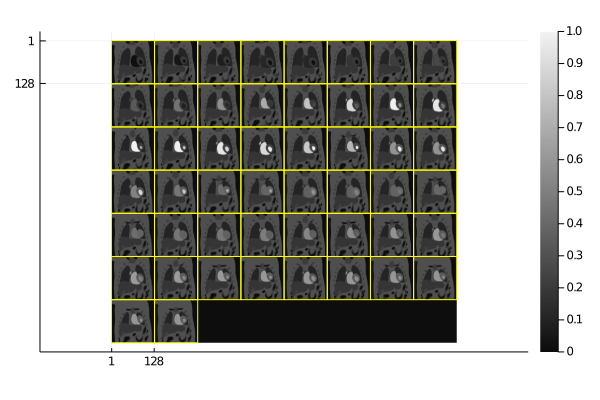

In [34]:
data = matread("../reproduce-l-s-dynamic-mri/data/aperiodic_pincat.mat")["new"]
Xtrue = permutedims(data, [2, 1, 3]) ./ maximum(data)
nx,ny,nt = size(Xtrue);
jim(Xtrue)

**Simulate coil maps**

`ir_mri_sensemap_sim` is part of MIRT.jl
 - https://github.com/JeffFessler/MIRT.jl/blob/master/src/mri/sensemap-sim.jl

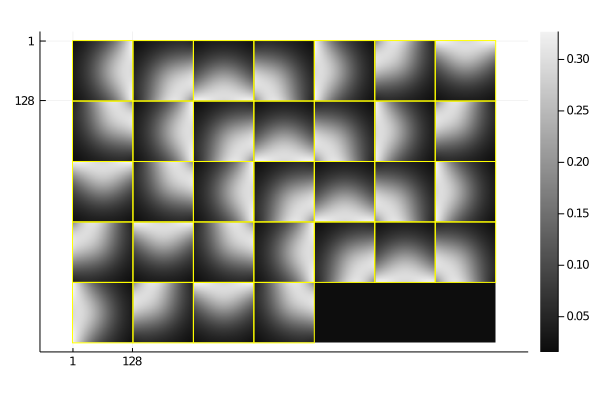

In [35]:
nc = 8;
nring = 4;
b1,_ = ir_mri_sensemap_sim(dims=(nx,ny), dx=1.5, dz=1.5,
    ncoil=nc*nring, nring=nring, rcoil=120, coil_distance=1.2, chat=false)
b1c = b1 ./ repeat(sqrt.(sum(abs2.(b1), dims=3)),outer=[1,1,nc*nring])
jim(b1c, abswarn=false)

**Coil compression to 8 coils**

MRI coil compression via PCA<br>
Given multiple MRI surface coil images (b1c), use SVD/PCA to find a smaller number of virtual coil images.

Function `ir_mri_coil_compress` is found in `helper_functions.jl`

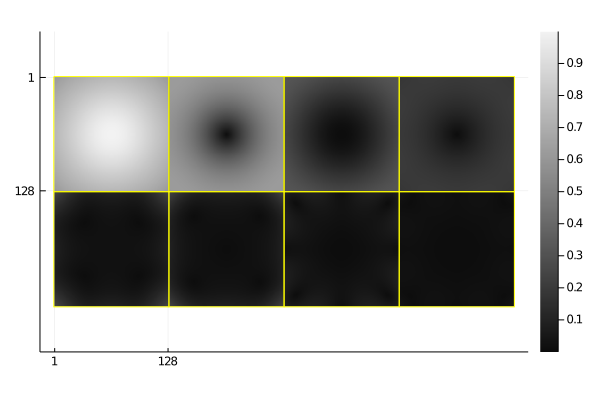

In [36]:
smap0,_,_ = ir_mri_coil_compress(b1c, ncoil=nc);
smap = smap0 ./ sqrt.(sum(abs2.(smap0), dims=3))
jim(smap, abswarn=false)

**Sampling mask**

Function `strucrand` is found in `helper_functions.jl`

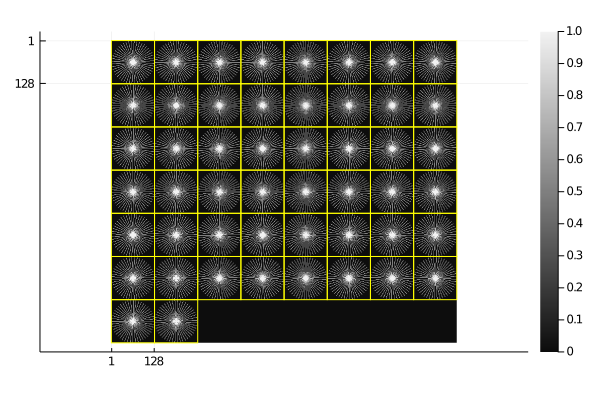

In [37]:
line = 24
samp = strucrand(nx, ny, nt, line)
pre_mask = fftshift(repeat(samp, 1, 1, 1, nc), 1:2)
mask = pre_mask .== 1
jim(samp)

**Acquisition operator and measured data**

In [38]:
E = getE(nx, ny, nt, nc, samp, smap, ComplexF64)
ytrue = E * ComplexF64.(Xtrue);

Get components of acquisition operator separately:

In [39]:
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, smap, ComplexF64)

(FunctionOperator{Complex{Float64}}(Ω, (128, 128, 50, 8), (128, 128, 50, 8)), FunctionOperator{Complex{Float64}}(Q, (128, 128, 50, 8), (128, 128, 50, 8)), FunctionOperator{Complex{Float64}}(C, (128, 128, 50, 1), (128, 128, 50, 8)))

**Add noise and prepare for regularization scaling**

Add complex noise such that the $SNR = 46dB$

In [40]:
noise = randn(Float32, size(ytrue)) + randn(Float32, size(ytrue))im # complex noise!
snr_dB = 46
scale_noise = norm(ytrue) / norm(noise) / 10^(snr_dB / 20.f0)
y = ytrue + scale_noise * noise
rms(x) = norm(x-ytrue) / sqrt(length(x-ytrue))
snr(x) = 20 * log10(norm(ytrue) / norm(x-ytrue))
@show rms(y)
@show snr(y);

rms(y) = 0.0004255057065161806
snr(y) = 45.99999940274094


**Sparsifying transform**

A Fourier transform along the time dimension

In [41]:
T = getT(nx, ny, nt, ComplexF64)

FunctionOperator with eltype Complex{Float64}
    Name: T
    Input dimensions: (16384, 50)
    Output dimensions: (16384, 50)

## 4.2 Test algorithms

In [ ]:
@time HM_IRLS(Xtrue, y, E, r̃ = 27, N = 10, verbose = true)

k = 0,	rank(Xᵏ) = 50,	‖Xᴳᵀ - Xᵏ‖₂ = 16.221, σ₁ = 209.624, ϵᵏ = 1.694
  1	1.28e+01
  2	1.30e+01
  3	1.43e+01
  4	7.10e+00
  5	7.18e+00
  6	5.92e+00
  7	5.63e+00
  8	2.90e+00
  9	4.80e+00
 10	2.96e+00
 11	1.81e+00
 12	2.39e+00
 13	1.81e+00
 14	1.31e+00
 15	1.09e+00
 16	1.32e+00
 17	1.01e+00
 18	7.18e-01
 19	7.02e-01
 20	7.98e-01
 21	4.90e-01
 22	4.44e-01
 23	4.82e-01
 24	4.55e-01
 25	3.01e-01
 26	2.88e-01
 27	3.35e-01
 28	2.18e-01
 29	2.17e-01
 30	2.12e-01
 31	2.00e-01
 32	1.39e-01
 33	1.42e-01
 34	1.42e-01
 35	1.24e-01
 36	1.10e-01
 37	1.10e-01
 38	1.14e-01
 39	7.41e-02
 40	9.41e-02
 41	8.44e-02
 42	8.97e-02
 43	7.01e-02
 44	8.46e-02
 45	8.93e-02
 46	6.10e-02
 47	9.22e-02
 48	8.30e-02
 49	8.24e-02
 50	6.82e-02
 51	9.03e-02
 52	9.18e-02
 53	7.43e-02
 54	8.92e-02
 55	9.42e-02
 56	7.60e-02
 57	7.20e-02
 58	8.62e-02
 59	8.78e-02
 60	7.38e-02
 61	7.02e-02
 62	8.81e-02
 63	5.80e-02
 64	6.45e-02
 65	6.29e-02
 66	7.19e-02
 67	5.25e-02
 68	4.97e-02
 69	6.62e-02
 70	3.85e-02
 71	4.62e-02
 72	3.71

Get scaling value required by all algorithms

In [22]:
x₀ = E' * y
St = svdvals(reshape(x₀ - E' * reshape(E * x₀ - y, nx, ny, nt, nc), nx*ny, nt));

**Run AL-CG**

In [23]:
@time L, S, rankL_cg, cost_cg =
    AL_CG(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//2, δ₂ = 1//2, verbose = true);

k = 0, rank = 50.0, cost = 948.4037897789445
k = 1, rank = 50.0, cost = 868.8501466674786
k = 2, rank = 50.0, cost = 817.9185145858019
k = 3, rank = 50.0, cost = 793.1090567417348
k = 4, rank = 50.0, cost = 767.3781921027046
k = 5, rank = 50.0, cost = 754.479602301253
k = 6, rank = 50.0, cost = 749.0112740304824
k = 7, rank = 50.0, cost = 745.0555511976013
k = 8, rank = 50.0, cost = 741.8175019400726
k = 9, rank = 50.0, cost = 738.1291800922108
k = 10, rank = 50.0, cost = 733.7351770980206
 36.686163 seconds (18.92 M allocations: 1.555 GiB, 0.35% gc time)


In [23]:
b = @benchmarkable AL_CG(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//2, δ₂ = 1//2)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  640.69 MiB
  allocs estimate:  13474
  --------------
  minimum time:     26.555 s (0.14% GC)
  median time:      27.011 s (0.14% GC)
  mean time:        26.891 s (0.10% GC)
  maximum time:     27.106 s (0.14% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run AL-2**

In [24]:
@time L, S, rankL_al, cost_al =
    AL_2(y, Ω, Q, C, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//3, δ₂ = 1//10, verbose = true);

k = 0, rank = 50.0, cost = 948.4037897789445
k = 1, rank = 3.0, cost = 1416.10849595794
k = 2, rank = 3.0, cost = 961.5206969728818
k = 3, rank = 5.0, cost = 817.0020062181428
k = 4, rank = 6.0, cost = 747.7827374773467
k = 5, rank = 7.0, cost = 724.4382171119966
k = 6, rank = 7.0, cost = 717.5590303786181
k = 7, rank = 8.0, cost = 712.8870852349952
k = 8, rank = 8.0, cost = 710.0813522512218
k = 9, rank = 8.0, cost = 708.5479734779117
k = 10, rank = 8.0, cost = 707.4469554221088
 13.289104 seconds (7.41 M allocations: 1.385 GiB, 2.68% gc time)


In [25]:
b = @benchmarkable AL_2(y, Ω, Q, C, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//3, δ₂ = 1//10)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.04 GiB
  allocs estimate:  5477
  --------------
  minimum time:     8.554 s (0.07% GC)
  median time:      8.557 s (0.07% GC)
  mean time:        8.558 s (0.09% GC)
  maximum time:     8.562 s (0.14% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run ISTA**

In [25]:
@time L, S, rankL_ista, cost_ista =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum = :ista, verbose = true);

k = 0, rank = 50.0, cost = 948.4037897789445
k = 1, rank = 22.0, cost = 785.2185459312408
k = 2, rank = 15.0, cost = 753.1842470327834
k = 3, rank = 14.0, cost = 740.0760171035539
k = 4, rank = 12.0, cost = 733.280488723967
k = 5, rank = 12.0, cost = 729.592452415826
k = 6, rank = 12.0, cost = 726.9402414111461
k = 7, rank = 12.0, cost = 724.8593151926975
k = 8, rank = 12.0, cost = 723.064605428363
k = 9, rank = 11.0, cost = 721.5554249046027
k = 10, rank = 11.0, cost = 720.2091360670004
 11.046650 seconds (11.65 M allocations: 1.139 GiB, 2.25% gc time)


In [27]:
b = @benchmarkable PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:ista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  627.79 MiB
  allocs estimate:  4252
  --------------
  minimum time:     6.063 s (0.15% GC)
  median time:      6.081 s (0.19% GC)
  mean time:        6.075 s (0.20% GC)
  maximum time:     6.082 s (0.27% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run FISTA**

In [26]:
@time L, S, rankL_fista, cost_fista =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:fista, verbose = true);

k = 0, rank = 50.0, cost = 948.4037897789445
k = 1, rank = 22.0, cost = 802.8748552278576
k = 2, rank = 13.0, cost = 776.1398623867565
k = 3, rank = 10.0, cost = 762.959223388114
k = 4, rank = 9.0, cost = 754.2609049551952
k = 5, rank = 9.0, cost = 749.3760338904506
k = 6, rank = 9.0, cost = 746.0766250285599
k = 7, rank = 9.0, cost = 743.5969626236081
k = 8, rank = 9.0, cost = 741.5879129159609
k = 9, rank = 9.0, cost = 739.9327622598693
k = 10, rank = 8.0, cost = 738.5441663459419
  6.949066 seconds (6.19 k allocations: 627.899 MiB, 1.21% gc time)


In [29]:
b = @benchmarkable PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:fista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  627.79 MiB
  allocs estimate:  4252
  --------------
  minimum time:     6.103 s (0.32% GC)
  median time:      6.133 s (0.27% GC)
  mean time:        6.130 s (0.24% GC)
  maximum time:     6.154 s (0.27% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run POGM**

In [27]:
@time L, S, rankL_pogm, cost_pogm =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:pogm, verbose = true);

k = 0, rank = 50.0, cost = 948.4037897789445
k = 1, rank = 22.0, cost = 789.5579826166862
k = 2, rank = 15.0, cost = 751.6172888237056
k = 3, rank = 13.0, cost = 736.6132270646615
k = 4, rank = 12.0, cost = 730.7781947427412
k = 5, rank = 12.0, cost = 727.1319974219797
k = 6, rank = 12.0, cost = 724.2306712915578
k = 7, rank = 12.0, cost = 721.5501908580943
k = 8, rank = 11.0, cost = 719.437855743483
k = 9, rank = 11.0, cost = 717.5198039663069
k = 10, rank = 11.0, cost = 714.325848532545
  6.815737 seconds (6.20 k allocations: 677.900 MiB, 0.44% gc time)


In [31]:
b = @benchmarkable PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:pogm)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  677.79 MiB
  allocs estimate:  4260
  --------------
  minimum time:     6.239 s (0.06% GC)
  median time:      6.260 s (0.06% GC)
  mean time:        6.265 s (0.06% GC)
  maximum time:     6.295 s (0.06% GC)
  --------------
  samples:          3
  evals/sample:     1

**Compare algorithms**

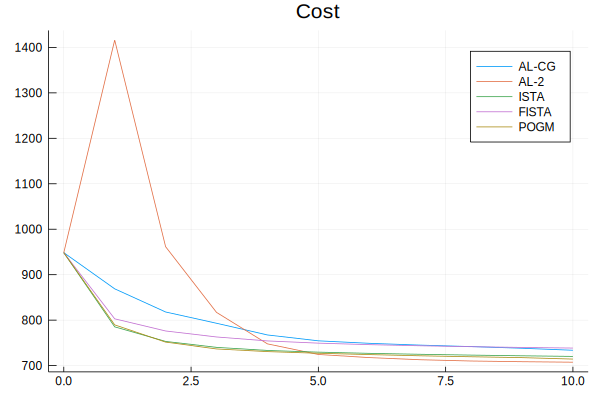

In [28]:
plot(0:10, collect(cost_cg), label="AL-CG", title = "Cost")
plot!(0:10, collect(cost_al), label="AL-2")
plot!(0:10, collect(cost_ista), label="ISTA")
plot!(0:10, collect(cost_fista), label="FISTA")
plot!(0:10, collect(cost_pogm), label="POGM")

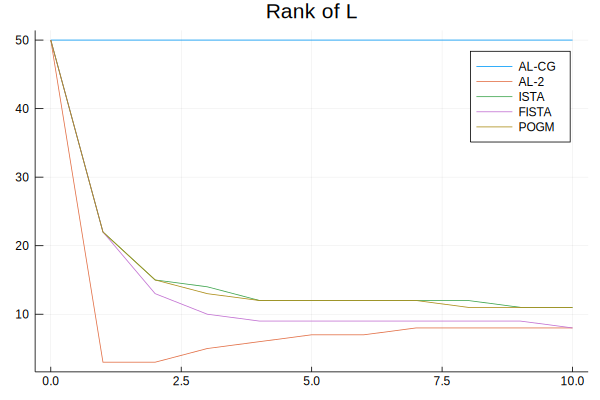

In [29]:
plot(0:10, collect(rankL_cg), label="AL-CG", title = "Rank of L")
plot!(0:10, collect(rankL_al), label="AL-2")
plot!(0:10, collect(rankL_ista), label="ISTA")
plot!(0:10, collect(rankL_fista), label="FISTA")
plot!(0:10, collect(rankL_pogm), label="POGM")

# 5. Multicoil cardiac cine MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_cine.m

## 5.1 Preparation

**Read data**

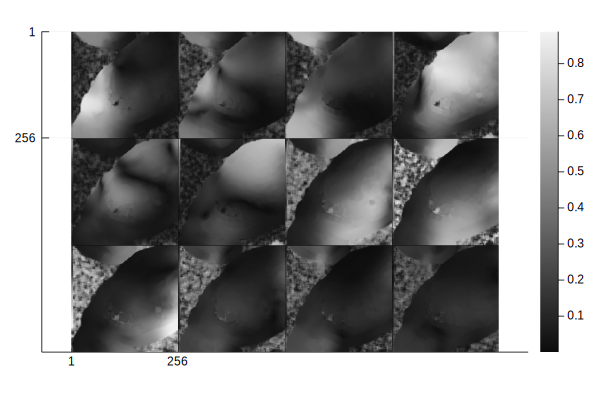

In [30]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_cine_R6.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

Sampling pattern:

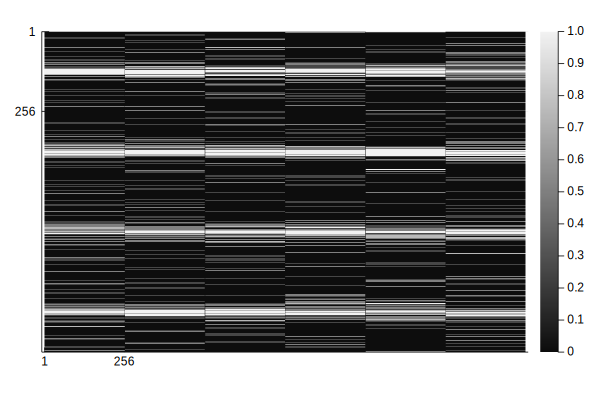

In [31]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [32]:
E = getE(nx, ny, nt, nc, samp, b1c, ComplexF64)
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, b1c, ComplexF64)
T = getT(nx, ny, nt, ComplexF64)

FunctionOperator with eltype Complex{Float64}
    Name: T
    Input dimensions: (65536, 24)
    Output dimensions: (65536, 24)

## 5.2 Test algorithms

**Run AL-CG**

In [33]:
@time L, S, rankL_cg, cost_cg = AL_CG(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//20, verbose = true);

k = 0, rank = 24.0, cost = 2056.647874472877
k = 1, rank = 24.0, cost = 718.8729327699734
k = 2, rank = 24.0, cost = 584.1764271341364
k = 3, rank = 24.0, cost = 560.6262624740905
k = 4, rank = 24.0, cost = 545.312494906107
k = 5, rank = 24.0, cost = 528.3746767976825
k = 6, rank = 24.0, cost = 517.4133751910122
k = 7, rank = 24.0, cost = 511.04770362936256
k = 8, rank = 24.0, cost = 504.2732691021006
k = 9, rank = 24.0, cost = 498.19424004092537
k = 10, rank = 24.0, cost = 492.8695828641496
 85.705445 seconds (45.31 k allocations: 1.386 GiB, 0.07% gc time)


In [38]:
b = @benchmarkable AL_CG(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//20)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.38 GiB
  allocs estimate:  13471
  --------------
  minimum time:     75.126 s (0.06% GC)
  median time:      76.181 s (0.06% GC)
  mean time:        76.118 s (0.07% GC)
  maximum time:     77.048 s (0.08% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run AL-2**

In [34]:
@time L, S, rankL_al, cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//100, verbose = true);

k = 0, rank = 24.0, cost = 2056.647874472877
k = 1, rank = 1.0, cost = 2365.87485678631
k = 2, rank = 1.0, cost = 798.3235798359684
k = 3, rank = 0.0, cost = 413.09944357704177
k = 4, rank = 0.0, cost = 323.3674695236738
k = 5, rank = 0.0, cost = 289.0024728352503
k = 6, rank = 0.0, cost = 269.17163082978476
k = 7, rank = 0.0, cost = 258.1183479121175
k = 8, rank = 0.0, cost = 251.88300763062125
k = 9, rank = 0.0, cost = 248.02441250687627
k = 10, rank = 0.0, cost = 245.17012076300114
 29.188547 seconds (451.11 k allocations: 2.670 GiB, 6.55% gc time)


In [40]:
b = @benchmarkable AL_2(kdata, Ω, Q, C, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//100)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  2.65 GiB
  allocs estimate:  5512
  --------------
  minimum time:     22.732 s (0.15% GC)
  median time:      22.747 s (0.11% GC)
  mean time:        22.755 s (0.11% GC)
  maximum time:     22.786 s (0.11% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run ISTA**

In [35]:
@time L, S, rankL_ista, cost_ista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:ista, verbose = true);

k = 0, rank = 24.0, cost = 2056.647874472877
k = 1, rank = 24.0, cost = 930.431210312366
k = 2, rank = 24.0, cost = 781.2870933272553
k = 3, rank = 24.0, cost = 708.2692299050374
k = 4, rank = 24.0, cost = 656.894970651201
k = 5, rank = 23.0, cost = 616.1078014067645
k = 6, rank = 21.0, cost = 582.5971010758706
k = 7, rank = 19.0, cost = 554.9013017248473
k = 8, rank = 16.0, cost = 531.6109624458317
k = 9, rank = 15.0, cost = 512.4119700464797
k = 10, rank = 13.0, cost = 496.7630088421726
 21.877100 seconds (24.55 k allocations: 1.362 GiB, 6.42% gc time)


In [42]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:ista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.36 GiB
  allocs estimate:  4249
  --------------
  minimum time:     16.340 s (0.11% GC)
  median time:      16.581 s (0.13% GC)
  mean time:        16.517 s (0.14% GC)
  maximum time:     16.630 s (0.19% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run FISTA**

In [36]:
@time L, S, rankL_fista, cost_fista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:fista, verbose = true);

k = 0, rank = 24.0, cost = 2056.647874472877
k = 1, rank = 24.0, cost = 1194.5046364629973
k = 2, rank = 24.0, cost = 867.4907072913508
k = 3, rank = 24.0, cost = 732.5141055041411
k = 4, rank = 22.0, cost = 650.8983623301244
k = 5, rank = 19.0, cost = 592.1919209254154
k = 6, rank = 16.0, cost = 548.0889971910246
k = 7, rank = 11.0, cost = 515.2445532944743
k = 8, rank = 8.0, cost = 491.85866624145393
k = 9, rank = 6.0, cost = 475.9161386237883
k = 10, rank = 4.0, cost = 465.83582404027317
 24.339300 seconds (6.19 k allocations: 1.361 GiB, 7.04% gc time)


In [44]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:fista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.36 GiB
  allocs estimate:  4249
  --------------
  minimum time:     16.447 s (0.22% GC)
  median time:      16.460 s (0.23% GC)
  mean time:        16.463 s (0.24% GC)
  maximum time:     16.483 s (0.23% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run POGM**

In [37]:
@time L, S, rankL_pogm, cost_pogm = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:pogm, verbose = true);

k = 0, rank = 24.0, cost = 2056.647874472877
k = 1, rank = 24.0, cost = 959.6629169195419
k = 2, rank = 24.0, cost = 772.3458365275952
k = 3, rank = 24.0, cost = 684.7385463571813
k = 4, rank = 24.0, cost = 619.0335959938639
k = 5, rank = 21.0, cost = 566.4411873424789
k = 6, rank = 16.0, cost = 524.8217275408289
k = 7, rank = 13.0, cost = 493.3634831957065
k = 8, rank = 8.0, cost = 472.56259691106834
k = 9, rank = 5.0, cost = 459.0823504331205
k = 10, rank = 3.0, cost = 450.5249583728417
 22.415979 seconds (6.20 k allocations: 1.454 GiB, 5.96% gc time)


In [46]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:pogm)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.45 GiB
  allocs estimate:  4257
  --------------
  minimum time:     16.608 s (0.02% GC)
  median time:      16.747 s (0.02% GC)
  mean time:        16.704 s (0.08% GC)
  maximum time:     16.759 s (0.20% GC)
  --------------
  samples:          3
  evals/sample:     1

**Compare algorithms**

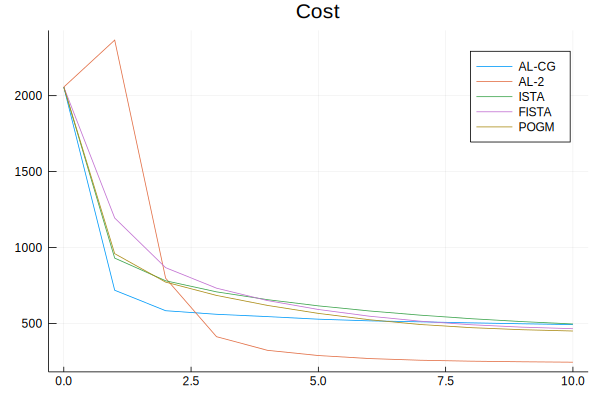

In [38]:
plot(0:10, collect(cost_cg), label="AL-CG", title = "Cost")
plot!(0:10, collect(cost_al), label="AL-2")
plot!(0:10, collect(cost_ista), label="ISTA")
plot!(0:10, collect(cost_fista), label="FISTA")
plot!(0:10, collect(cost_pogm), label="POGM")

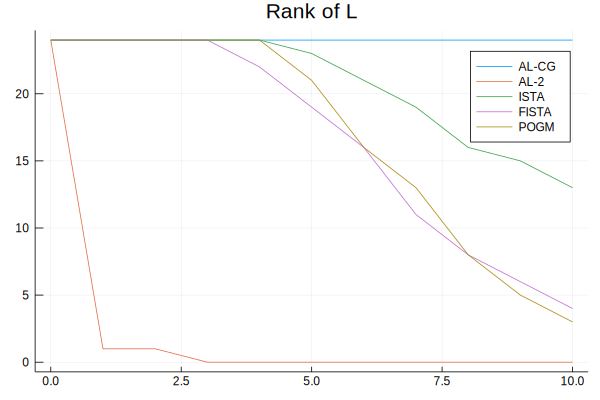

In [39]:
plot(0:10, collect(rankL_cg), label="AL-CG", title = "Rank of L")
plot!(0:10, collect(rankL_al), label="AL-2")
plot!(0:10, collect(rankL_ista), label="ISTA")
plot!(0:10, collect(rankL_fista), label="FISTA")
plot!(0:10, collect(rankL_pogm), label="POGM")

# 6. Multicoil cardiac perfusion MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_perf.m

## 6.1 Preparation

**Read data**

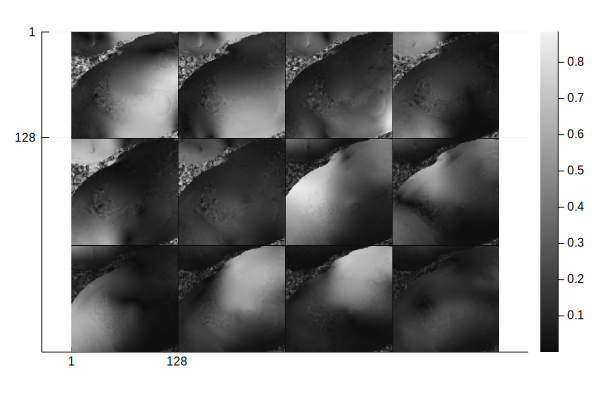

In [40]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_perf_R8.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

Sampling pattern:

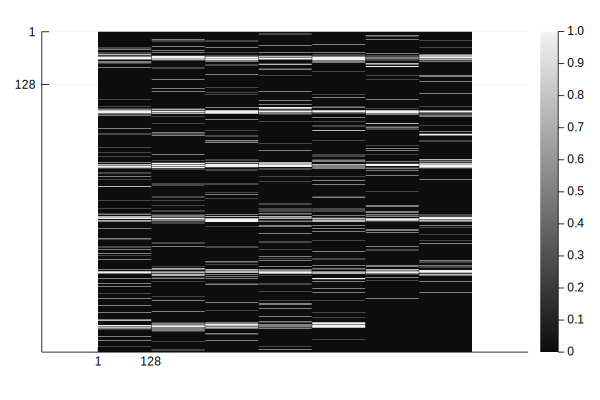

In [41]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [42]:
E = getE(nx, ny, nt, nc, samp, b1c, ComplexF64)
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, b1c, ComplexF64)
T = getT(nx, ny, nt, ComplexF64)

FunctionOperator with eltype Complex{Float64}
    Name: T
    Input dimensions: (16384, 40)
    Output dimensions: (16384, 40)

## 6.2 Test algorithms

**Run AL-CG**

In [43]:
@time L, S, rankL_cg, cost_cg = AL_CG(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1//5, δ₂ = 1//5, verbose = true);

k = 0, rank = 40.0, cost = 1605.909098593462
k = 1, rank = 40.0, cost = 685.8410743871815
k = 2, rank = 40.0, cost = 585.7224251200573
k = 3, rank = 40.0, cost = 532.0409719803743
k = 4, rank = 40.0, cost = 500.1502294025973
k = 5, rank = 40.0, cost = 481.39433803597205
k = 6, rank = 40.0, cost = 469.22513739051914
k = 7, rank = 40.0, cost = 460.37132605131364
k = 8, rank = 40.0, cost = 453.48191200976
k = 9, rank = 40.0, cost = 448.2498619007965
k = 10, rank = 40.0, cost = 444.4316580436256
 37.300703 seconds (17.52 k allocations: 592.771 MiB, 1.64% gc time)


In [53]:
b = @benchmarkable AL_CG(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1//5, δ₂ = 1//5)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  592.54 MiB
  allocs estimate:  13472
  --------------
  minimum time:     32.312 s (0.00% GC)
  median time:      32.979 s (0.00% GC)
  mean time:        32.828 s (0.00% GC)
  maximum time:     33.194 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run AL-2**

In [44]:
@time L, S, rankL_al, cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1//5, δ₂ = 1//50, verbose = true);

k = 0, rank = 40.0, cost = 1605.909098593462
k = 1, rank = 1.0, cost = 2919.109850635982
k = 2, rank = 1.0, cost = 1310.481111764481
k = 3, rank = 3.0, cost = 820.5040168998246
k = 4, rank = 3.0, cost = 642.2338446919746
k = 5, rank = 4.0, cost = 552.3495333501075
k = 6, rank = 5.0, cost = 500.75927438156816
k = 7, rank = 5.0, cost = 469.7612700708031
k = 8, rank = 4.0, cost = 450.63058498775797
k = 9, rank = 4.0, cost = 438.60395228154107
k = 10, rank = 4.0, cost = 430.68032007858704
 10.619030 seconds (7.44 k allocations: 1012.304 MiB, 0.07% gc time)


In [55]:
b = @benchmarkable AL_2(kdata, Ω, Q, C, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1//5, δ₂ = 1//50)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  1.11 GiB
  allocs estimate:  5513
  --------------
  minimum time:     9.908 s (0.04% GC)
  median time:      10.003 s (0.04% GC)
  mean time:        10.010 s (0.04% GC)
  maximum time:     10.120 s (0.04% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run ISTA**

In [45]:
@time L, S, rankL_ista, cost_ista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:ista, verbose = true);

k = 0, rank = 40.0, cost = 1605.909098593462
k = 1, rank = 40.0, cost = 818.9382257398181
k = 2, rank = 40.0, cost = 707.3174310720563
k = 3, rank = 40.0, cost = 650.9061843089784
k = 4, rank = 40.0, cost = 611.9376380902602
k = 5, rank = 37.0, cost = 582.288216594289
k = 6, rank = 35.0, cost = 558.7976569091923
k = 7, rank = 32.0, cost = 539.7249939102525
k = 8, rank = 29.0, cost = 523.9214778076403
k = 9, rank = 28.0, cost = 510.56374109249055
k = 10, rank = 27.0, cost = 499.09504263613474
  7.962301 seconds (6.19 k allocations: 582.254 MiB)


In [57]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:ista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  582.14 MiB
  allocs estimate:  4250
  --------------
  minimum time:     7.617 s (0.00% GC)
  median time:      7.637 s (0.00% GC)
  mean time:        7.635 s (0.00% GC)
  maximum time:     7.651 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run FISTA**

In [46]:
@time L, S, rankL_fista, cost_fista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:fista, verbose = true);

k = 0, rank = 40.0, cost = 1605.909098593462
k = 1, rank = 40.0, cost = 1032.1930042184847
k = 2, rank = 40.0, cost = 791.313055895339
k = 3, rank = 37.0, cost = 686.5086086560468
k = 4, rank = 32.0, cost = 625.915370908722
k = 5, rank = 27.0, cost = 584.4385668435486
k = 6, rank = 24.0, cost = 553.7099863480104
k = 7, rank = 21.0, cost = 529.7860067016113
k = 8, rank = 18.0, cost = 510.6394470094643
k = 9, rank = 17.0, cost = 495.1846388123587
k = 10, rank = 15.0, cost = 483.9001649842685
  9.424026 seconds (6.19 k allocations: 582.254 MiB, 1.38% gc time)


In [59]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:fista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  582.14 MiB
  allocs estimate:  4250
  --------------
  minimum time:     7.792 s (0.00% GC)
  median time:      7.852 s (0.00% GC)
  mean time:        7.924 s (0.00% GC)
  maximum time:     8.129 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run POGM**

In [47]:
@time L, S, rankL_pogm, cost_pogm = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:pogm, verbose = true);

k = 0, rank = 40.0, cost = 1605.909098593462
k = 1, rank = 40.0, cost = 845.719650195787
k = 2, rank = 40.0, cost = 701.51832195973
k = 3, rank = 40.0, cost = 634.722852922222
k = 4, rank = 40.0, cost = 585.6027816423962
k = 5, rank = 36.0, cost = 547.4927072431954
k = 6, rank = 31.0, cost = 517.9527494800798
k = 7, rank = 28.0, cost = 494.65222209808263
k = 8, rank = 24.0, cost = 476.0098696524616
k = 9, rank = 21.0, cost = 461.29638034080403
k = 10, rank = 18.0, cost = 450.2237748565137
  9.271383 seconds (6.20 k allocations: 622.254 MiB)


In [61]:
b = @benchmarkable PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:pogm)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  622.14 MiB
  allocs estimate:  4258
  --------------
  minimum time:     7.078 s (0.00% GC)
  median time:      7.079 s (0.00% GC)
  mean time:        7.083 s (0.00% GC)
  maximum time:     7.092 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

**Compare algorithms**

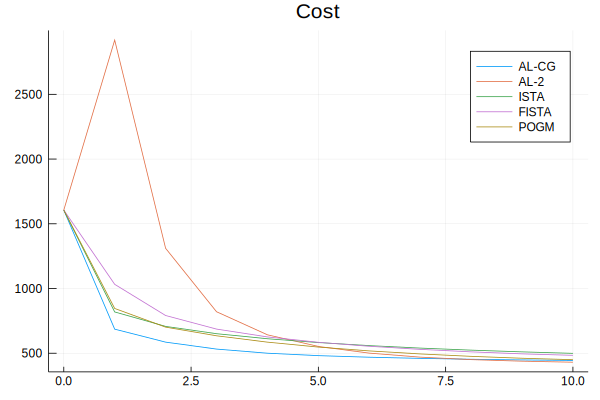

In [48]:
plot(0:10, collect(cost_cg), label="AL-CG", title = "Cost")
plot!(0:10, collect(cost_al), label="AL-2")
plot!(0:10, collect(cost_ista), label="ISTA")
plot!(0:10, collect(cost_fista), label="FISTA")
plot!(0:10, collect(cost_pogm), label="POGM")

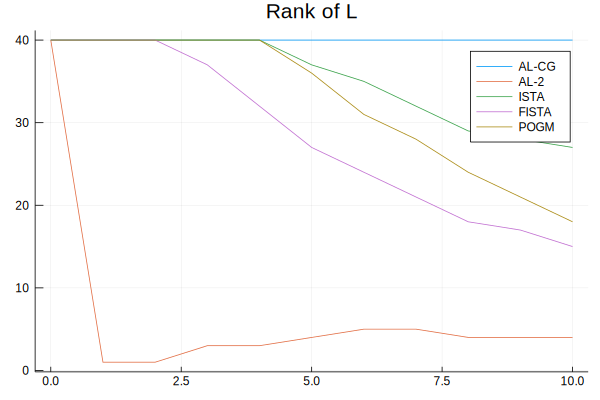

In [49]:
plot(0:10, collect(rankL_cg), label="AL-CG", title = "Rank of L")
plot!(0:10, collect(rankL_al), label="AL-2")
plot!(0:10, collect(rankL_ista), label="ISTA")
plot!(0:10, collect(rankL_fista), label="FISTA")
plot!(0:10, collect(rankL_pogm), label="POGM")

# 7. Multicoil abdominal dce MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_abdomen_dce_ga.m

## 7.1 Preparation

**Read data**

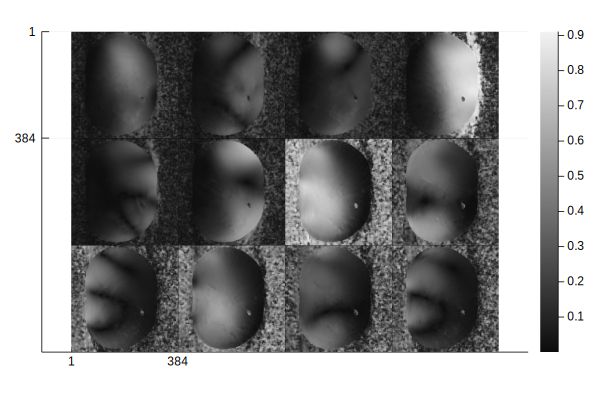

In [50]:
data = matread("../reproduce-l-s-dynamic-mri/data/abdomen_dce_ga.mat")
w, kdata, k, b1 = data["w"], data["kdata"], data["k"], data["b1"]
nspokes = 21 # number of spokes to be used per frame (Fibonacci number)
nx,ny,nc = size(b1)
nr,ntviews,nc = size(kdata)
nt = ntviews ÷ nspokes # number of frames

# crop the data according to the number of spokes per frame:
kdata = kdata[:,1:nt*nspokes,:]
k = k[:,1:nt*nspokes]
w = w[:,1:nt*nspokes]

# sort the data into a time-series of undersampled images:
kdatau = Array{Complex{Float64}}(undef, nr, nspokes, nc, nt)
ku = Array{Complex{Float64}}(undef, nr, nspokes, nt)
wu = Array{Complex{Float64}}(undef, nr, nspokes, nt)
for ii = 1:nt
    kdatau[:,:,:,ii] = kdata[:,(ii-1)*nspokes+1:ii*nspokes,:]
    ku[:,:,ii] = k[:,(ii-1)*nspokes+1:ii*nspokes]
    wu[:,:,ii] = w[:,(ii-1)*nspokes+1:ii*nspokes]
end

# prepare for system operator
ksp = reshape(ku, nr*nspokes, nt)
ksp3 = Array{Float64}(undef, nr*nspokes, 2, nt)
ksp3[:,1,:] = real(ksp)
ksp3[:,2,:] = imag(ksp)
om3 = ksp3*2*pi
wi3 = reshape(wu, nr*nspokes, nt)
M = size(ksp,1)

# normalize smap
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

## 7.2 Test algorithms

In [51]:
E = getEnufft(b1c, ksp=ksp3, om=om3, wi=wi3, dType=ComplexF64)
d = permutedims(reshape(kdatau, nx*nspokes, nc, nt), [1 3 2])
recon_nufft = E' * d
T = getT(nx, ny, nt, ComplexF64)
img_shape = (nx, ny, nt)

(384, 384, 28)

**Run ISTA**

In [52]:
@time L, S, rankL_ista, cost_ista = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:ista,
    verbose = true);

k = 0, rank = 28.0, cost = 0.15637310104440194
k = 1, rank = 28.0, cost = 0.1204846630112464
k = 2, rank = 28.0, cost = 0.09515875367728156
k = 3, rank = 28.0, cost = 0.0771013616527453
k = 4, rank = 28.0, cost = 0.06409089653377514
k = 5, rank = 28.0, cost = 0.05461308087840721
k = 6, rank = 28.0, cost = 0.04762771409983331
k = 7, rank = 28.0, cost = 0.04241490700488715
k = 8, rank = 28.0, cost = 0.03847437427976227
k = 9, rank = 28.0, cost = 0.03545796106962959
k = 10, rank = 28.0, cost = 0.03312016578175388
101.036579 seconds (5.55 M allocations: 2.425 GiB, 1.06% gc time)


In [67]:
b = @benchmarkable PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:ista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  2.18 GiB
  allocs estimate:  29714
  --------------
  minimum time:     74.430 s (0.06% GC)
  median time:      75.062 s (0.07% GC)
  mean time:        75.277 s (0.14% GC)
  maximum time:     76.339 s (0.30% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run FISTA**

In [53]:
@time L, S, rankL_fista, cost_fista = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:fista,
    verbose = true);

k = 0, rank = 28.0, cost = 0.15637310104440194
k = 1, rank = 28.0, cost = 0.14160172534784554
k = 2, rank = 28.0, cost = 0.1254017965570319
k = 3, rank = 28.0, cost = 0.11042690769552069
k = 4, rank = 27.0, cost = 0.09740621251252828
k = 5, rank = 24.0, cost = 0.08638087910262188
k = 6, rank = 21.0, cost = 0.07714749091670278
k = 7, rank = 20.0, cost = 0.06944586677657856
k = 8, rank = 19.0, cost = 0.06301018869129975
k = 9, rank = 17.0, cost = 0.057600329201815674
k = 10, rank = 17.0, cost = 0.05355557407260022
100.075032 seconds (31.65 k allocations: 2.175 GiB, 2.50% gc time)


In [69]:
b = @benchmarkable PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:fista)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  2.18 GiB
  allocs estimate:  29714
  --------------
  minimum time:     73.486 s (0.07% GC)
  median time:      73.798 s (0.06% GC)
  mean time:        73.700 s (0.06% GC)
  maximum time:     73.816 s (0.06% GC)
  --------------
  samples:          3
  evals/sample:     1

**Run POGM**

In [54]:
@time L, S, rankL_pogm, cost_pogm = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:pogm,
    verbose = true);

k = 0, rank = 28.0, cost = 0.15637310104440194
k = 1, rank = 28.0, cost = 0.12815933226108692
k = 2, rank = 28.0, cost = 0.09750662624929322
k = 3, rank = 28.0, cost = 0.07031483044706487
k = 4, rank = 28.0, cost = 0.049486082688822694
k = 5, rank = 28.0, cost = 0.03550043793632376
k = 6, rank = 28.0, cost = 0.027238283707865223
k = 7, rank = 28.0, cost = 0.02292864046030179
k = 8, rank = 28.0, cost = 0.020906832137774004
k = 9, rank = 28.0, cost = 0.02001717585370241
k = 10, rank = 28.0, cost = 0.019860173965690047
 93.528239 seconds (31.66 k allocations: 2.421 GiB, 2.13% gc time)


In [71]:
b = @benchmarkable PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:pogm)
run(b, seconds=Inf, samples=3)

BenchmarkTools.Trial: 
  memory estimate:  2.42 GiB
  allocs estimate:  29722
  --------------
  minimum time:     72.699 s (0.06% GC)
  median time:      73.644 s (0.06% GC)
  mean time:        73.489 s (0.06% GC)
  maximum time:     74.122 s (0.06% GC)
  --------------
  samples:          3
  evals/sample:     1

**Compare algorithms**

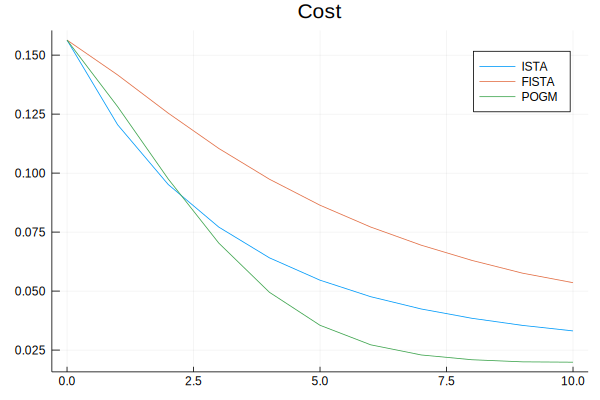

In [55]:
plot(0:10, collect(cost_ista), label="ISTA", title = "Cost")
plot!(0:10, collect(cost_fista), label="FISTA")
plot!(0:10, collect(cost_pogm), label="POGM")

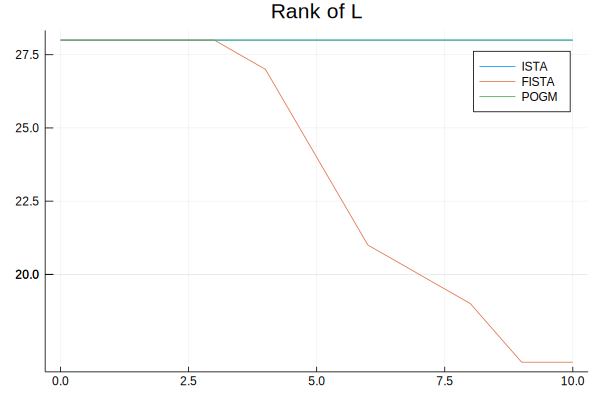

In [56]:
plot(0:10, collect(rankL_ista), label="ISTA", title = "Rank of L")
plot!(0:10, collect(rankL_fista), label="FISTA")
plot!(0:10, collect(rankL_pogm), label="POGM")